In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import re


In [8]:
def load_data():
  data = pd.read_json(r"/content/dataset.json",orient="index")
  return data



data = load_data()
print(data.shape)


(20148, 4)


In [9]:
# Accessing the 'label' from the first dictionary within each list in the 'annotators' column
# This creates a new Series containing just the extracted 'label' values.
# We use a lambda function with .apply() to safely access the first element and its 'label' key.
extracted_labels = data['annotators'].apply(lambda x: x[0]['label'] if isinstance(x, list) and len(x) > 0 else None)

# Now, count the unique values of these extracted labels
#extracted_labels.value_counts()

In [10]:
###############################################
#Replace the column value "Offensive" to "Hatespeech as tey almost the same"
extracted_labels = extracted_labels.replace("offensive","hatespeech")
#extracted_labels.value_counts()

In [11]:
data["labels"] = extracted_labels

In [12]:
# Extract target values only from the first annotator in each row
# Handle cases where the 'annotators' list is empty or the 'target' key is missing.
first_annotator_targets = data['annotators'].apply(
    lambda x: x[0]['target'] if isinstance(x, list) and len(x) > 0 and 'target' in x[0] else []
)

# Flatten the list of lists into a single Series of individual target values
# The .explode() method is used here to transform each element of a list-like entry into a separate row.
exploded_targets = first_annotator_targets.explode()

# Convert to pandas Series and get value counts of these individual targets
first_annotator_target_counts = exploded_targets.value_counts()

# Display the target counts
display(first_annotator_target_counts)

,count
annotators,
None,7170
African,3309
Islam,2218
Women,2060
Jewish,1958
Homosexual,1862
Other,1649
Refugee,1038
Arab,1005


In [13]:
data["target_group"] = first_annotator_targets

In [14]:
data = data.drop(["post_id","annotators"],axis=1)
#data.columns

In [15]:
data['texts'] = data['post_tokens'].apply(lambda x: " ".join(x))
data.drop(["rationales"],axis=1,inplace=True)

In [16]:
target_groups = ["religous","racial","gender"]
data['target_group'] = data['target_group'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

def classify_target_group(target_str):
    if not isinstance(target_str, str):
        return 'Other'

    target_str_lower = target_str.lower()

    # Define keywords for each main category
    religious_keywords = ['islam', 'jewish', 'christian', 'nonreligious', 'hindu']
    racial_keywords = ['african', 'asian', 'caucasian', 'hispanic', 'arab', 'indigenous', 'indian', 'minority']
    gender_keywords = ['women', 'men', 'homosexual', 'heterosexual']

    # Check for categories in the user's specified order: Religious, Racial, Gender
    if any(keyword in target_str_lower for keyword in religious_keywords):
        return 'Religious'
    if any(keyword in target_str_lower for keyword in racial_keywords):
        return 'Racial'
    if any(keyword in target_str_lower for keyword in gender_keywords):
        return 'Gender'

    # Handle 'None' explicitly if it means no specific target group
    if 'none' in target_str_lower:
        return 'None' # If a target group was originally '[None]', it became 'None' string.

    return 'Other' # Default for anything not matching above, including 'Other', 'Refugee', 'Disability', 'Economic'

data['target_group'] = data['target_group'].apply(classify_target_group)

In [17]:
data

,post_tokens,labels,target_group,texts
1179055004553900032_twitter,"[i, dont, think, im, getting, my, baby, them, ...",normal,None,i dont think im getting my baby them white 9 h...
1179063826874032128_twitter,"[we, cannot, continue, calling, ourselves, fem...",normal,None,we cannot continue calling ourselves feminists...
1178793830532956161_twitter,"[nawt, yall, niggers, ignoring, me]",normal,Racial,nawt yall niggers ignoring me
1179088797964763136_twitter,"[<user>, i, am, bit, confused, coz, chinese, p...",hatespeech,Racial,<user> i am bit confused coz chinese ppl can n...
1179085312976445440_twitter,"[this, bitch, in, whataburger, eating, a, burg...",hatespeech,Racial,this bitch in whataburger eating a burger with...
...,...,...,...,...
9989999_gab,"[if, ur, still, on, twitter, tell, carlton, i,...",hatespeech,Gender,if ur still on twitter tell carlton i said his...
9990225_gab,"[when, i, first, got, on, here, and, said, i, ...",hatespeech,Racial,when i first got on here and said i hate trump...
9991681_gab,"[was, macht, der, moslem, wenn, der, zion, geg...",hatespeech,Religious,was macht der moslem wenn der zion gegen seine...
9992513_gab,"[it, is, awful, look, at, world, demographics,...",hatespeech,Racial,it is awful look at world demographics asians ...


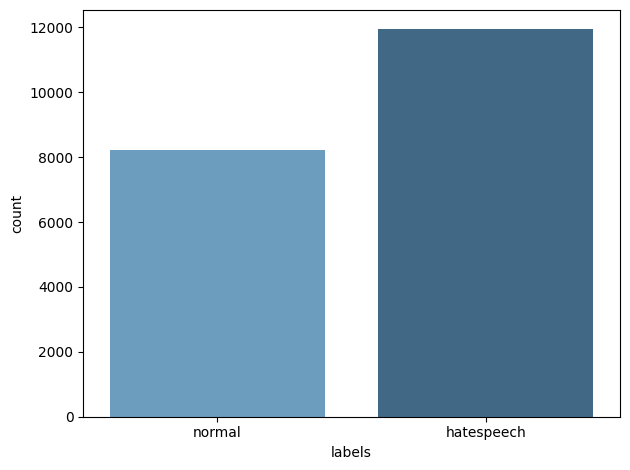

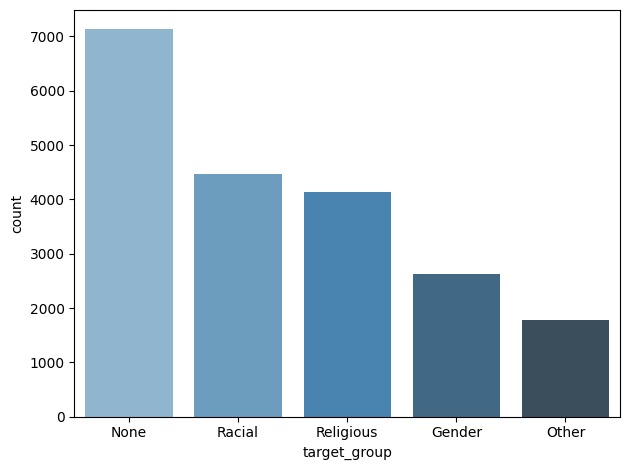

In [18]:
import warnings
warnings.filterwarnings('ignore')
###################################################
#LABEL DISTRUBUTION
# Source - https://stackoverflow.com/a/37347844
# Posted by IanS, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-30, License - CC BY-SA 4.0

# Convert list of targets to a comma-separated string
data['target_group'] = data['target_group'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

for col in ['labels', 'target_group']:
     sns.countplot(x=col, data=data,palette='Blues_d')
     plt.tight_layout()
     plt.show()

In [19]:

data['token_count'] = data['post_tokens'].apply(len)
mean = data['token_count'].mean()
median = data['token_count'].median()
max = data['token_count'].max()
min = data['token_count'].min()



words_below_5 = 0
for val in data['token_count']:
  if  val< 5:
    words_below_5 += 1















print("Mean:", mean)
print("Median:", median)
print("Max:", max)
print("Min:", min)
print("Number of samples below 5 tokens:" ,words_below_5)


Mean: 23.570279928528887
Median: 21.0
Max: 165
Min: 2
Number of samples below 5 tokens: 532


In [20]:
data

,post_tokens,labels,target_group,texts,token_count
1179055004553900032_twitter,"[i, dont, think, im, getting, my, baby, them, ...",normal,None,i dont think im getting my baby them white 9 h...,20
1179063826874032128_twitter,"[we, cannot, continue, calling, ourselves, fem...",normal,None,we cannot continue calling ourselves feminists...,42
1178793830532956161_twitter,"[nawt, yall, niggers, ignoring, me]",normal,Racial,nawt yall niggers ignoring me,5
1179088797964763136_twitter,"[<user>, i, am, bit, confused, coz, chinese, p...",hatespeech,Racial,<user> i am bit confused coz chinese ppl can n...,26
1179085312976445440_twitter,"[this, bitch, in, whataburger, eating, a, burg...",hatespeech,Racial,this bitch in whataburger eating a burger with...,20
...,...,...,...,...,...
9989999_gab,"[if, ur, still, on, twitter, tell, carlton, i,...",hatespeech,Gender,if ur still on twitter tell carlton i said his...,33
9990225_gab,"[when, i, first, got, on, here, and, said, i, ...",hatespeech,Racial,when i first got on here and said i hate trump...,28
9991681_gab,"[was, macht, der, moslem, wenn, der, zion, geg...",hatespeech,Religious,was macht der moslem wenn der zion gegen seine...,23
9992513_gab,"[it, is, awful, look, at, world, demographics,...",hatespeech,Racial,it is awful look at world demographics asians ...,17


[0 0 0 ... 1 1 1]
Accuracy: 0.5992555831265509
F1: 0.7494181536074477


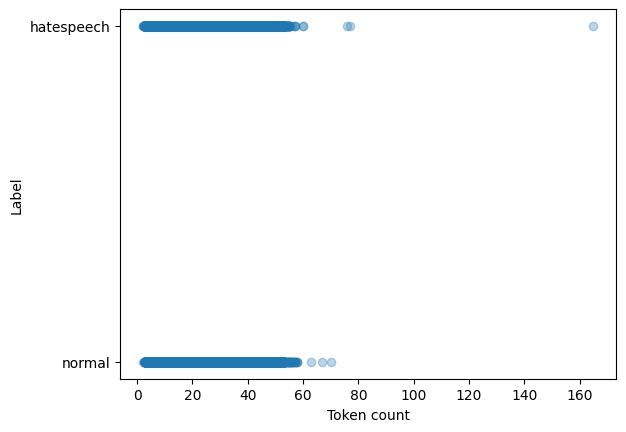

,token_count
labels,
hatespeech,23.633889
normal,23.477768


In [21]:
################################
#now dataset biased with length????

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score # Import accuracy_score and f1_score

data['label_bin'] = data['labels'].map({
    'normal': 0,
    'hatespeech': 1
})

# Correctly reshape X to be a 2D array with (n_samples, n_features)
X = data['token_count'].values.reshape(-1, 1)
y = data['label_bin'].values
print(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) # Added random_state for reproducibility
model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, pred))
print("F1:", f1_score(y_test, pred))



plt.scatter(data['token_count'], data['labels'], alpha=0.3)
plt.xlabel("Token count")
plt.ylabel("Label")
plt.show()


data.groupby("labels")["token_count"].mean()

